In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
import netCDF4 as nc
import os
import numpy as np
import numpy.ma as ma
#from IPython import embed
def get1(fn):
    with nc.Dataset(fn, 'r') as f:
        a,b,c = f.variables['Bathymetry'][:], f.variables['nav_lon'][:], f.variables['nav_lat'][:]
    return a,b,c
bp,lonp,latp    = get1('/home/mdunphy/MEOPAR/NEMO-forcing/grid/bathymetry_201702.nc')
with nc.Dataset('/home/mdunphy/MEOPAR/NEMO-forcing/grid/mesh_mask201702.nc') as mm:
    tmask = mm.variables['tmask'][0,0,...]

In [2]:
def get(fn,var,k,tmask=None):
    with nc.Dataset(fn, 'r') as ncf:
        if len(ncf.variables[var].shape) == 4:
            v = ncf.variables[var][0,k,...]
        else:
            v = ncf.variables[var][k,...]
        if tmask is None:
            vm = ma.masked_array(v, mask=(v==0))
        else:
            vm = ma.masked_array(v, mask=1-tmask)
        print("range:",np.min(vm),np.max(vm))
        return vm

In [3]:
rsp  = '/results/SalishSea/hindcast/17dec14/SalishSea_00198720_restart.nc'

In [4]:
from salishsea_tools import viz_tools, geo_tools
dx = geo_tools.haversine(lonp[0,0],latp[0,0],lonp[0,-1],latp[0,-1])
dy = geo_tools.haversine(lonp[0,0],latp[0,0],lonp[-1,0],latp[-1,0])
ar = dy/dx
print(dx,dy,ar)
dx = geo_tools.haversine(lonp[-1,0],latp[-1,0],lonp[-1,-1],latp[-1,-1])
dy = geo_tools.haversine(lonp[0,-1],latp[0,-1],lonp[-1,-1],latp[-1,-1])
ar = dy/dx
print(dx,dy,ar)


179.329894394 448.819367539 2.50275822141
165.086846823 446.576653655 2.70510135877


In [5]:
#ax1.set_xlim(-124.94,-122.85)   # VOODOO!
#ax1.set_ylim(46.6,51.55)    # VOODOO!

#t2=ax2.transData
#bxx=np.array([[-126.0, 45.0],[-123.0, 52.0]])
#print(t2.transform_affine(bxx))


#pts=[[   lonp[0,0], latp[0,0]  ],[   lonp[-1,-1],latp[-1,-1]   ]]
#b = mt.Bbox.from_extents(pts)
#r=t1.transform_affine(pts)

#r=ax1.transAxes.transform_affine(pts)

#exts=[[   np.min(lonp), np.min(latp),  ],[   np.max(lonp), np.max(latp) ]]
#exts=[[   lonp[0,0], latp[0,0]  ],[   lonp[-1,-1],latp[-1,-1]   ]]
#b = mt.Bbox.from_extents(exts)
#r=mt.BboxBase.rotated(b,np.radians(-40))
#r=mt.BboxBase.transformed(b,tr)
#r=t1.transform_bbox(b)

#ax1.set_xlim(r.xmin,r.xmax)
#ax1.set_ylim(r.ymin,r.ymax)
#ax1.set_xlim(-150,-100)   # VOODOO!
#ax1.set_ylim(15,55)    # VOODOO!


range: 7.77169898843e-300 32.0462608136


<IPython.core.display.Javascript object>


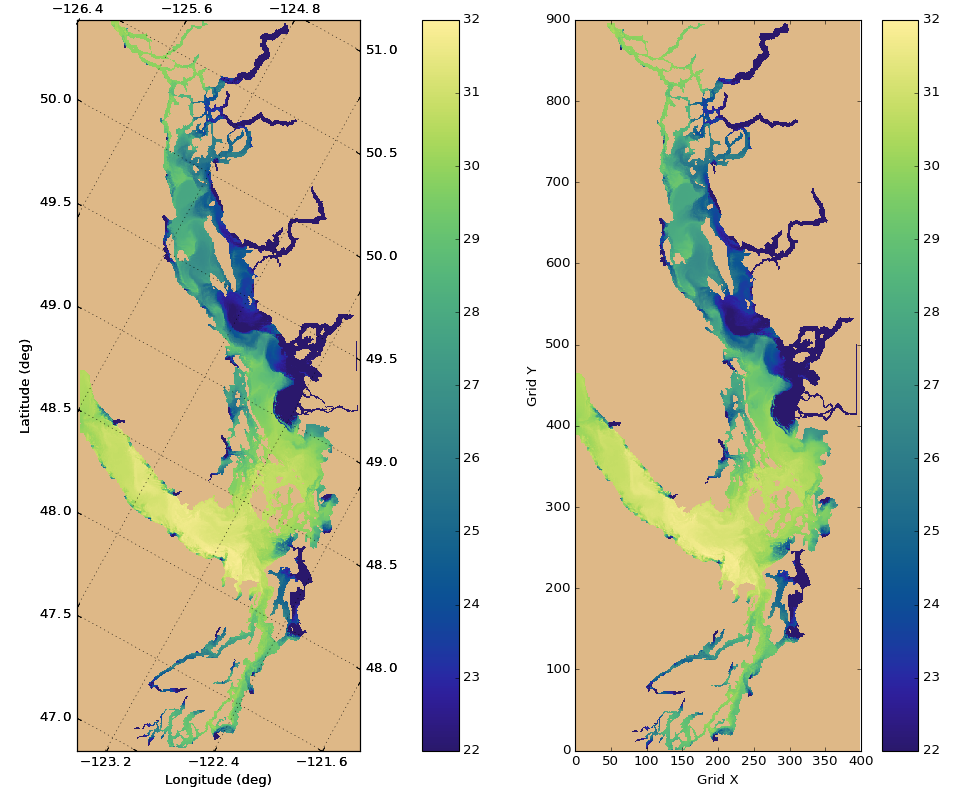

In [18]:
from mpl_toolkits.axisartist import SubplotHost, ParasiteAxesAuxTrans
from mpl_toolkits.axisartist.grid_helper_curvelinear import GridHelperCurveLinear
import matplotlib.transforms as mt
import cmocean.cm as cm

cmap = plt.get_cmap(cm.haline)
cmap.set_bad('burlywood')
c1,c2 = 22,32
var, k = 'sn', 0
ap = get(rsp,var,k,tmask)


fig = plt.figure(figsize=(12, 10))
fig.clf()

tr = mt.Affine2D().scale(np.cos(np.mean(np.radians(latp))),1).rotate_deg(-29)
grid_helper = GridHelperCurveLinear(tr)
ax1 = SubplotHost(fig, 1, 2, 1, grid_helper=grid_helper)

# make ticklabels of right and top axis visible.
ax1.axis["right"].major_ticklabels.set_visible(True)
ax1.axis["top"].major_ticklabels.set_visible(True)
fig.add_subplot(ax1)

# A parasite axes with given transform
ax2 = ParasiteAxesAuxTrans(ax1, tr, "equal")
# note that ax2.transData == tr + ax1.transData
# Anything you draw in ax2 will match the ticks and grids of ax1.
ax1.parasites.append(ax2)

pc=ax2.pcolormesh(lonp,latp, ap, vmin=c1,vmax=c2, cmap=cmap)
fig.colorbar(pc, pad=0.15)

# Run the corners through the transform
pts=np.array([lonp.flatten(),latp.flatten()]).T
r=tr.transform_affine(pts)
xx,yy = r[:,0],r[:,1]
x0,x1 = np.min(xx),np.max(xx)
y0,y1 = np.min(yy),np.max(yy)
ax1.set_xlim(x0,x1)
ax1.set_ylim(y0,y1)

ax1.set_xlabel('Longitude (deg)')
ax1.set_ylabel('Latitude (deg)')
ax1.set_axis_bgcolor('burlywood')
ax1.grid(True, zorder=1)
ax1.set_aspect(1)

if 1:
    ######### reference at right 
    ax9 = plt.subplot(1,2,2)
    pcc=ax9.pcolormesh(ap, vmin=c1,vmax=c2, cmap=cmap)
    fig.colorbar(pcc, pad=0.05)
    ax9.set_xlabel('Grid X')
    ax9.set_ylabel('Grid Y')
    ax9.set_aspect(5/4.4)
    plt.tight_layout(pad=1,h_pad=1)
plt.draw()
plt.show()

In [12]:
np.cos(np.radians(np.min(latp))), np.cos(np.radians(np.max(latp))), 

(0.68378762396861947, 0.62789784149876871)